In [1]:
import numpy as np
import pandas as pd

from datetime import datetime
import time
import os
import glob

import random
from collections import deque

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization


%matplotlib inline

In [2]:
path = os.path.join("D:",os.sep, "Datasets","Stock","h1")
# os.listdir(path)

In [3]:
# read all data and create low price dataframe into 1 dataframed
df= pd.DataFrame()
for (root, dirs ,files) in os.walk(path):
    for f in files:
        df_tmp = pd.read_csv(os.path.join(path,f), delimiter='\t')
        Instrument = f.split('_')[0] 
        Instrument = Instrument[:3] + '-' + Instrument[3:]
        df_tmp.set_index('Time', inplace=True)
        
        df_tmp.rename(columns={"Close":f"{Instrument}_Close", "Volume":f"{Instrument}_Volume"}, inplace=True)
        df_tmp = df_tmp[[f"{Instrument}_Close", f"{Instrument}_Volume"]]
        
        df = df.join(df_tmp, how='right')

        print(Instrument + ' has updated!')
    

df.fillna(method='ffill', inplace=True)
df.dropna(inplace=True)

# Export Data to a csv for furthur usage
df.to_csv('../Dataset/stock.csv')

EUR-GBP has updated!
EUR-USD has updated!
GBP-USD has updated!
USD-JPY has updated!


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99674 entries, 2007-07-24 23:00:00 to 2023-08-01 04:00:00
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   EUR-GBP_Close   99674 non-null  float64
 1   EUR-GBP_Volume  99674 non-null  float64
 2   EUR-USD_Close   99674 non-null  float64
 3   EUR-USD_Volume  99674 non-null  float64
 4   GBP-USD_Close   99674 non-null  float64
 5   GBP-USD_Volume  99674 non-null  float64
 6   USD-JPY_Close   99674 non-null  float64
 7   USD-JPY_Volume  99674 non-null  int64  
dtypes: float64(7), int64(1)
memory usage: 6.8+ MB


In [5]:
df.isna().sum()
# Visually check for null values
# sns.heatmap(df.isna(), cbar=True, yticklabels=False)

EUR-GBP_Close     0
EUR-GBP_Volume    0
EUR-USD_Close     0
EUR-USD_Volume    0
GBP-USD_Close     0
GBP-USD_Volume    0
USD-JPY_Close     0
USD-JPY_Volume    0
dtype: int64

In [6]:
# df

<Axes: xlabel='Time'>

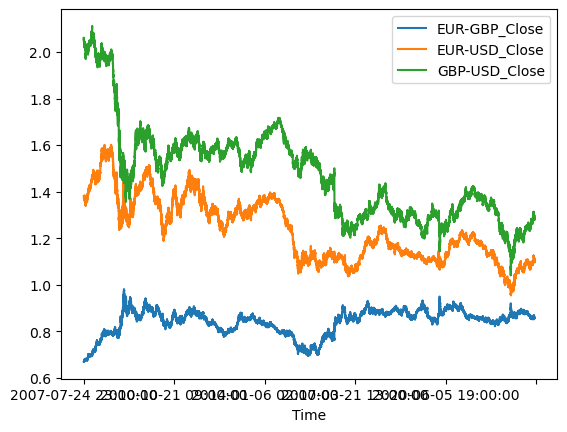

In [7]:
# preview price fluctuation
df[['EUR-GBP_Close', 'EUR-USD_Close', 'GBP-USD_Close']].plot()

In [8]:
# sequence length (timeframe length)
period_len = 60
# step which predict after timefreame has trained (arbitrary value)
next_item_predict = 3
# Instrument to predict
predict_ratio = 'GBP-USD'

In [9]:
# choose next nth step as future value to predict and concat to df
# its a dummy variable just to use in calculation
df['future'] = df[f'{predict_ratio}_Close'].shift(-next_item_predict)

In [10]:
# determine if price goes up(expensive) or not
# this function is simple as returns 1 in case of price increament which means take buy position and vice versa
# we may develop the function as return differentiaion value, so the problem must consideredc as regression

def price_classification(current, future):
    if float(current) > float(future):
        return 0 
    else:
        return 1
    

In [11]:
df['target'] = list(map(price_classification, df[f'{predict_ratio}_Close'], df['future']))

## Split train and test data

In [12]:
time_steps = sorted(df.index.values)
# last 5% of timesteps
last_5_pcent = sorted(df.index.values)[-int(0.05 * len(time_steps))]

#create validation data, which index is gt last 5 percent of data
validation_df = df[(df.index) >= last_5_pcent]

#main data turns to first 95% of timeframes
df =  df[(df.index) < last_5_pcent]

In [13]:
# df.columns
def preproc_data(df:pd.DataFrame):
    
    if 'future' in df.columns:
        df.drop('future', axis=1, inplace=True)
    
    for col in df.columns:
        if col != 'target': # normolize all columns, except the target
            # normalize each instrument. calculate relations based on percent change rather than value
            df[col].pct_change()
            df.dropna(inplace=True)
            df[col] = preprocessing.scale(df[col].values) # Scale between 0 and 1
        
    df.dropna(inplace=True) # cleanup again, because nan may generate during percentage change ops



    ## Create sequences and Shuffle data

    # Make data as timeseries

    sequential_data = []
    prev_days = deque(maxlen=period_len)

    for i in df.values:
        prev_days.append([n for n in i[:-1]]) #keep all except the target
        if len(prev_days) == period_len:
            # insert every indivudual date prices, for period length days in this case 60 days
            # i[-1] is the target of 60th day target (last day of period)
            sequential_data.append([np.array(prev_days), i[-1]])


    # now shuffle data
    random.shuffle(sequential_data)

    ## Balance data with down sampling (buy/sell)

    buys = [] # to store buy data
    sells = [] # to store sell data

    # separate buys and sells records
    for seq, target in sequential_data:
        if target == 0: # if its sell
            sells.append([seq, target]) 
        elif target == 1: # if its buy
            buys.append([seq, target])

    # preview each category samples count, to grasp down sampling
    print(f"sell samples: {len(sells)} \t buy samples: {len(buys)}")
    
    random.shuffle(buys) # shuffle buy list
    random.shuffle(sells) # shuffle buy list

    lower = min(len(buys), len(sells)) # Find Shortest list

    # make both lists same length as shortest
    buys = buys[:lower] 
    sells = sells[:lower]

    # concat buys and sells
    sequential_data = buys + sells
    random.shuffle(sequential_data)

    X = []
    y = []

    for seq, target in sequential_data:
        X.append(seq)
        y.append(target)

    #X = np.array(X)

    return np.array(X), y

In [14]:
X_train, y_train = preproc_data(df)
X_test, y_test = preproc_data(validation_df)


sell samples: 47016 	 buy samples: 47616
sell samples: 2370 	 buy samples: 2554


In [15]:
X_train.shape
#returns (samples, timesteps, features) which is require by RNN

(94032, 60, 8)

In [16]:
np.array(y_train).shape

(94032,)

In [17]:
# as you see, data has balanced
print(f"overall data: \t train data: {len(X_train)},\t test data:{len(X_test)}")
print(f"train data: \t sells: {y_train.count(0)},\t\t buys:{y_train.count(1)}")
print(f"test data: \t sells: {y_test.count(0)},\t\t buys:{y_test.count(1)}")



overall data: 	 train data: 94032,	 test data:4740
train data: 	 sells: 47016,		 buys:47016
test data: 	 sells: 2370,		 buys:2370


## Timeseries Price Prediction - RNN Model

In [18]:
# model hyperparameter
i_epchos = 10
i_batch_size = 64

In [19]:
model = Sequential()

# First RNN Layer with LSTM
model.add(LSTM(128, input_shape=(X_train.shape[1:]), return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

# return_sequences=True -> will return this layer hidden state as netx rnn layer input


# Second RNN Layer (adding this layer, will create Deep RNN Stack)
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.1))
model.add(BatchNormalization())

# Third RNN Layer
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

# now, rnn out put pass to a fully connected layer
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

# a classifier to separate final oooutput
model.add(Dense(2, activation='softmax'))

# could use single cell .... instead softmax for classification


In [32]:
# Defien optimizer for model
# opt = tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-6)
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, decay=1e-6)

# Compile Mode
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)


In [33]:
model.input

<KerasTensor: shape=(None, 60, 8) dtype=float32 (created by layer 'lstm_input')>

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 128)           70144     
                                                                 
 dropout (Dropout)           (None, 60, 128)           0         
                                                                 
 batch_normalization (BatchN  (None, 60, 128)          512       
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 60, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 60, 128)           0         
                                                                 
 batch_normalization_1 (Batc  (None, 60, 128)          512       
 hNormalization)                                        

In [35]:
# train the model
history = model.fit(
    x=X_train, 
    y=np.array(y_train),
    batch_size=i_batch_size,
    epochs=i_epchos,
    validation_data=(X_test, np.array(y_test))
)

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "C:\Users\104974068\AppData\Local\anaconda3\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\104974068\AppData\Local\anaconda3\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\104974068\AppData\Local\anaconda3\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\104974068\AppData\Local\anaconda3\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\Users\104974068\AppData\Local\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 711, in start
      self.io_loop.start()
    File "C:\Users\104974068\AppData\Local\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\104974068\AppData\Local\anaconda3\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "C:\Users\104974068\AppData\Local\anaconda3\lib\asyncio\base_events.py", line 1906, in _run_once
      handle._run()
    File "C:\Users\104974068\AppData\Local\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\104974068\AppData\Local\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\104974068\AppData\Local\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\104974068\AppData\Local\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\104974068\AppData\Local\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\104974068\AppData\Local\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "C:\Users\104974068\AppData\Local\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\104974068\AppData\Local\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "C:\Users\104974068\AppData\Local\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "C:\Users\104974068\AppData\Local\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\104974068\AppData\Local\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\104974068\AppData\Local\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\104974068\AppData\Local\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\104974068\AppData\Local\Temp\ipykernel_15532\3223319142.py", line 2, in <module>
      history = model.fit(
    File "C:\Users\104974068\AppData\Local\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\104974068\AppData\Local\anaconda3\lib\site-packages\keras\engine\training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\104974068\AppData\Local\anaconda3\lib\site-packages\keras\engine\training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "C:\Users\104974068\AppData\Local\anaconda3\lib\site-packages\keras\engine\training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\104974068\AppData\Local\anaconda3\lib\site-packages\keras\engine\training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "C:\Users\104974068\AppData\Local\anaconda3\lib\site-packages\keras\engine\training.py", line 1051, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\104974068\AppData\Local\anaconda3\lib\site-packages\keras\engine\training.py", line 1109, in compute_loss
      return self.compiled_loss(
    File "C:\Users\104974068\AppData\Local\anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\104974068\AppData\Local\anaconda3\lib\site-packages\keras\losses.py", line 142, in __call__
      losses = call_fn(y_true, y_pred)
    File "C:\Users\104974068\AppData\Local\anaconda3\lib\site-packages\keras\losses.py", line 268, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\104974068\AppData\Local\anaconda3\lib\site-packages\keras\losses.py", line 2078, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "C:\Users\104974068\AppData\Local\anaconda3\lib\site-packages\keras\backend.py", line 5660, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
logits and labels must have the same first dimension, got logits shape [3840,2] and labels shape [64]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_26929]